<a href="https://colab.research.google.com/github/manthangadhia/Data-Mining-Music-Year-Prediction/blob/main/Deep_Learning_Practical_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# Deep Learning Report
SOW-BKI 230A

### Manthan Gadhia $-$ s1032698

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==0.16.2

In [2]:
import mxnet as mx
from d2l import mxnet as d2l

In [3]:
from mxnet import np, npx, autograd, gluon, init
from mxnet.gluon import nn

npx.set_np()

from IPython import display
import numpy
import matplotlib.pyplot as plt

In [4]:
npx.num_gpus()   # Output: 1 --- confirming that colab is running on GPU

1

In [6]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

---

# Introduction
(Book chapter 2)

The exercises done in this section:
*   2.1.8: 1, 2
*   2.2.5: 1, 2
*   2.3.13: 1-3
*   2.4.6: 1-4
*   2.5.6: 1, 2





---
### Exercise 2.1.8

---
#### 2.8.1: 1
Using the definitions of `X, Y` from the code provided in the book, change the conditional `X == Y` to `X < Y` or `X > Y`, and then see what kind of tensor you get.



In [ ]:
X = np.arange(12).reshape(3, 4)
Y = np.array([[2, 1, 4, 3], [1, 2, 3, 4], [4, 3, 2, 1]])

print('X == Y:\n', X==Y)
print('X > Y:\n', X > Y)
print('X < Y:\n', X < Y)

X == Y:
 [[False  True False  True]
 [False False False False]
 [False False False False]]
X > Y:
 [[False False False False]
 [ True  True  True  True]
 [ True  True  True  True]]
X < Y:
 [[ True False  True False]
 [False False False False]
 [False False False False]]


**Answer:**
> It is noteworthy that the shapes of the resulting tensors in the case of both operations is the same as the shapes of `X` and `Y`, and also that the result seems to compare each element in `X` to the element in `Y` corresponding to the exact same index.

---
#### 2.8.1: 2
Replace the two tensors that operate by element in the broadcasting mechanism with other shapes. Is the result the same as expected?

In [ ]:
a = np.arange(12).reshape(1, 3, 4)
b = np.arange(3).reshape(1, 3, 1)
a, b

(array([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.]]]), array([[[0.],
         [1.],
         [2.]]]))

In [ ]:
a + b

array([[[ 0.,  1.,  2.,  3.],
        [ 5.,  6.,  7.,  8.],
        [10., 11., 12., 13.]]])

**Answer:**
> Changing the shapes of the tensors needs to be done carefully if I want the broadcasting mechanism to work implicitly. I need to make sure that there is at least one tensor, which has one of it's axes being of size 1. Along with this, at most one axis can be mismatched in size. If more than one axis is mismatched, then the broadcasting fails to happen successfully.
>
> Other than this limitation, the results obtained match the expected results.

---
### Exercise 2.2.5
Create a raw dataset.

In [ ]:
import os

os.makedirs(os.path.join('..', 'data'), exist_ok=True)
df = os.path.join('..', 'data', 'data-preprocessing.csv')

with open(df, 'w') as f:
    f.write('NumRooms,Alley,NumWindows,Size,Price\n')  # Column names
    f.write('NA,Pave,12,87,127500\n')  # Each row represents a data example
    f.write('2,NA,NA,80,106000\n')
    f.write('4,Pave,23,NA,178100\n')
    f.write('NA,NA,NA,95,140000\n')
    f.write('3,Pave,NA,66,86400\n')
    f.write('4,Pave,9,103,167000\n')
    f.write('5,Pave,NA,NA,145000\n')
    f.write('2,Pave,NA,55,136700\n')
    f.write('6,Pave,NA,112,204800\n')

---
#### 2.2.5: 1
Delete the column with the most missing values.

In [ ]:
import pandas as pd

data = pd.read_csv(df)
print(data)

   NumRooms Alley  NumWindows   Size   Price
0       NaN  Pave        12.0   87.0  127500
1       2.0   NaN         NaN   80.0  106000
2       4.0  Pave        23.0    NaN  178100
3       NaN   NaN         NaN   95.0  140000
4       3.0  Pave         NaN   66.0   86400
5       4.0  Pave         9.0  103.0  167000
6       5.0  Pave         NaN    NaN  145000
7       2.0  Pave         NaN   55.0  136700
8       6.0  Pave         NaN  112.0  204800


In [ ]:
data.isna().sum()
  # The .isna() function returns a boolean dataframe indication each empty cell.
  # Then using the .sum() function adds, across each column, the number of empty cells.

NumRooms      2
Alley         2
NumWindows    6
Size          2
Price         0
dtype: int64

**Answer:**
> From the output of the code cell above, we know that `NumWindows` has the most missing values: 6.
> 
> This means we can delete that column.

In [ ]:
data = data.drop('NumWindows', 1)
print(data)

   NumRooms Alley   Size   Price
0       NaN  Pave   87.0  127500
1       2.0   NaN   80.0  106000
2       4.0  Pave    NaN  178100
3       NaN   NaN   95.0  140000
4       3.0  Pave   66.0   86400
5       4.0  Pave  103.0  167000
6       5.0  Pave    NaN  145000
7       2.0  Pave   55.0  136700
8       6.0  Pave  112.0  204800


---
#### 2.2.5: 2
Convert the data from the previous question to the tensor format.

In [ ]:
inputs, outputs = data.iloc[:, 0:3], data.iloc[:, 3]
inputs = inputs.fillna(inputs.mean())
inputs = pd.get_dummies(inputs, dummy_na=True)
print(inputs)

   NumRooms        Size  Alley_Pave  Alley_nan
0  3.714286   87.000000           1          0
1  2.000000   80.000000           0          1
2  4.000000   85.428571           1          0
3  3.714286   95.000000           0          1
4  3.000000   66.000000           1          0
5  4.000000  103.000000           1          0
6  5.000000   85.428571           1          0
7  2.000000   55.000000           1          0
8  6.000000  112.000000           1          0


In [ ]:
X, y = np.array(inputs.values), np.array(outputs.values)
X, y

(array([[  3.71428571,  87.        ,   1.        ,   0.        ],
        [  2.        ,  80.        ,   0.        ,   1.        ],
        [  4.        ,  85.42857143,   1.        ,   0.        ],
        [  3.71428571,  95.        ,   0.        ,   1.        ],
        [  3.        ,  66.        ,   1.        ,   0.        ],
        [  4.        , 103.        ,   1.        ,   0.        ],
        [  5.        ,  85.42857143,   1.        ,   0.        ],
        [  2.        ,  55.        ,   1.        ,   0.        ],
        [  6.        , 112.        ,   1.        ,   0.        ]], dtype=float64),
 array([127500, 106000, 178100, 140000,  86400, 167000, 145000, 136700,
        204800], dtype=int64))

---
### Exercise 2.3.13

---
#### 2.3.13: 1
Prove that the transpose of a transpose of a matrix $\mathbf{A}$ is equal to $\mathbf{A}$.

In [ ]:
# The initial Matrix A
A = np.arange(15).reshape(3,-1)

# Transpose(A)
B = A.T

# Transpose(B) <=> Transpose(Transpose(A))
C = B.T

# Check equality
A == C

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

Clearly, from the output of the code cell above, we can see that given an arbitrary matrix $\mathbf{A}$, $(\mathbf{A}^{\top})^{\top} = \mathbf{A}$.

---
#### 2.3.13: 2
Given two matrices $\mathbf{A,B}$, show that the sum of transposes is equal to the transpose of the sum.

In [ ]:
A = np.arange(15).reshape(3,-1)
B = np.arange(3).reshape(3,-1)
print(A)
print(B)

[[ 0.  1.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [10. 11. 12. 13. 14.]]
[[0.]
 [1.]
 [2.]]


In [ ]:
# Transpose the two matrices and sum
A_t = A.T
B_t = B.T
sum_of_transpose = A_t + B_t

# Sum the two matrices and transpose
sum_AB = A + B
transpose_of_sum = sum_AB.T

# Check equality
sum_of_transpose == transpose_of_sum

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

As seen from the output of the code cell above consisting of `True` boolean values, it is indeed the case that given two matrices $\mathbf{A,B}$, it holds that: $\mathbf{A}^{\top} + \mathbf{B}^{\top} = (\mathbf{A} + \mathbf{B})^{\top}$

---
#### 2.3.13: 3
Given any square matrix $\mathbf{A}$, is $\mathbf{A} + \mathbf{A}^{\top}$ always symetric? Why?

In [ ]:
dims = [2,3,4,5]

# for all m*m matrices, m in dims
# print shape of A + Transpose(A)
for d in dims:
  mat = np.arange((d*d)).reshape(d,d)
  mat_t = mat.T
  sum = mat + mat_t
  print('Dimension: {}, Shape: {}'.format(d, sum.shape))

Dimension: 2, Shape: (2, 2)
Dimension: 3, Shape: (3, 3)
Dimension: 4, Shape: (4, 4)
Dimension: 5, Shape: (5, 5)


As seen from the output of the code cell above, it does hold for all square matrices $\mathbf{A}$ that $\mathbf{A} + \mathbf{A}^{\top}$.

This is the case because for all square matrices, their tranposed matrix has the same dimensions (i.e. it is also a square). And performing summation $\mathbf{A} + \mathbf{B}$ on all matrices $\mathbf{A},\mathbf{B}$ is computed as an *element-wise* operation. Therefore, if the shapes of the input matrices are identical, these dimensions are maintained for the output matrix; otherwise the broadcast mecahnism is attempted.

---

### Exercise 2.4.6

The following functions have been copied directly from code blocks provided in the textbook.

In [ ]:
from d2l import mxnet as d2l

def use_svg_display(): 
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')
    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def set_figsize(figsize=(3.5, 2.5)): 
    """Set the figure size for matplotlib."""
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else d2l.plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or
                isinstance(X, list) and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)


---
#### 2.4.6: 1
Plot the function $y = f(x) = x^{3} - \frac{1}{x}$ and it's tangent line when $x = 1$.


***Note:***
*The function `numerical_lim` was also copied directly from the textbook.*

In [ ]:
def f(x):
  return (x ** 3) - (1 / x)

def numerical_lim(f, x, h):
    return (f(x + h) - f(x)) / h

h = 0.1
for i in range(5):
    print(f'h={h:.5f}, numerical limit={numerical_lim(f, 1, h):.5f}')
    h *= 0.1


h=0.10000, numerical limit=4.21909
h=0.01000, numerical limit=4.02020
h=0.00100, numerical limit=4.00200
h=0.00010, numerical limit=4.00020
h=0.00001, numerical limit=4.00002


**Answer:**
> It is clearly visible that the derivative of $f(x), x=1$ approaches $4$.
> 
> Therefore the equation of the tangent line is $y = 4x - 4$ where the *slope* $4$ was acquired through differentiation, and the *y-intercept* was acquired through performing simple algebra.

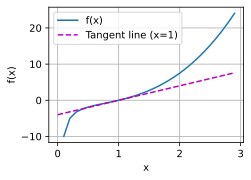

In [ ]:
x = np.arange(0, 3, 0.1)
plot(x, [f(x), 4*x - 4], 'x', 'f(x)', legend=['f(x)', 'Tangent line (x=1)'])


---
#### 2.4.6: 2

Find the gradient of the following function $f(\mathbf{x}) = 3x^{2} + 5e^{x^{2}}$.

**Answer:**

> To find the answer, we need to differentiate the equation (given that $\mathbf{x}$ is a vector).
>
>$$
\begin{aligned}
  \nabla f(\mathbf{x}) &= \nabla \big(3x^{2} + 5e^{x^{2}}\big) \\
  &= \nabla \big(3x^{2}\big)\; +\; \nabla\big(5e^{x^{2}}\big) \\
  \text{Using the power rule:} \\
  &= (6x)\; +\; \nabla\big(5e^{x^{2}}\big) \\
  \text{Pulling out constant:} \\
  &= (6x)\; +\; 5\nabla\big(e^{x^{2}}\big) \\
  \text{Then differentiate $e$:} \\
  &= (6x)\; +\; 5\big(2 \cdot e^{x^{2}} \cdot x\big) \\
  &= 6x + 10e^{x^{2}}x
\end{aligned}
$$

---
#### 2.4.6: 3

What is the gradient of the function: $f(\mathbf{x}) = ||\mathbf{x}||^{2}$?

**Answer:**

> Using the rule in shown in the book to carry out differentiation on multivariate functions:
>
>$$
\begin{aligned}
  \nabla_{\mathbf{x}} f(\mathbf{x}) &= \nabla_{\mathbf{x}} ||\mathbf{x}||^{2} \\ 
  &= \nabla_{\mathbf{x}} \mathbf{x}^{\top}\mathbf{x} \\
  &= 2\mathbf{x}
\end{aligned}
$$

---
#### 2.4.6: 4

Write out the chain rule for the case where $u = f(x,y,z)\; \text{and}\; x = x(a,b),\; y = y(a,b),\; \text{and}\; z = z(a,b)$.

**Answer:**

> Using the general **chain rule of differentiation** discussed in this section of the book, $u$ can be differentiated in 2 ways since it has two main variables $a$ and $b$:
>
>$$
\begin{aligned}
   & \frac{du}{da} &= \Big(\frac{du}{dx}\Big)\Big(\frac{dx}{da}\Big)\; +\; \Big(\frac{du}{dy}\Big)\Big(\frac{dy}{da}\Big)\; +\; \Big(\frac{du}{dz}\Big)\Big(\frac{dz}{da}\Big)\; \\
   \text{and} & & \\
   & \frac{du}{db} &= \Big(\frac{du}{dx}\Big)\Big(\frac{dx}{db}\Big)\; +\; \Big(\frac{du}{dy}\Big)\Big(\frac{dy}{db}\Big)\; +\; \Big(\frac{du}{dz}\Big)\Big(\frac{dz}{db}\Big)\; \\
\end{aligned}
$$

---
### Exercise 2.5.6

---
#### 2.5.6: 1
Why is computing a second derivative so much more expensive than computing the first?

> **Answer:**
>
> This is because given any vector $\mathbf{x}$, calculating the first derivative of $N$ elements requires has the complexity $O(N)$ since a partial derivative is performed on every element once. However for the second derivative, for each element, $N$ more partial derivatives need to be computed such that $N^{2}$ operations are being performed. This results in a complexity of $O(N^{2})$ making this exponentially expensive to compute.

---
#### 2.5.6: 2

After running the function for backpropagation, immediately run it again and see what happens.

In [ ]:
# Create vector x
x = np.arange(4)
x.attach_grad()

# Build computational graph
with autograd.record():
  y = 2 * np.dot(x, x)
  z = 2 * np.dot(x, x)

In [ ]:
# First run backpropagation once
y.backward()
x.grad

array([ 0.,  4.,  8., 12.])

In [ ]:
# Then run backpropagation twice
z.backward()
z.backward()
x.grad

MXNetError: ignored

> **Answer:**
>
> Clearly we can see from the outputs of the two code cells above that running the backpropagation function a second time results in an error that `the node cannot be differentiated because it is not in the computational graph.` Differentiating the same node twice requires extra parameters to be passed, specifically `retain_graph=True` needs to be passed to the backward call.

---
---
# Linear Neural Networks
(Book Chapter 3)

The exercises to be done in this section:
* 3.1.6: 2
* 3.2.9: 1, 6
* 3.6.9: 1, 4

----
### Exercise 3.1.6

Linear Regression


---
#### 3.1.6: 2

Derive the analytic solution to the optimization problem for linear regression with squared error. To keep things simple, you can omit the bias $b$ from the problem (we can do this in principled fashion by adding one column to $\mathbf{X}$ consisting of all ones).

> **Answer:**
>
> As discussed in the book, the following is the equation which needs to be minimised: $||\mathbf{y - Xw}||^{2}$ i.e. the parameter we are looking for $\mathbf{w}^{*} = \text{argmin}_{\mathbf{w}}\, L(\mathbf{w}) = \text{argmin}_{\mathbf{w}}\,(||\mathbf{y - Xw}||^{2})$.
>
> `1. Write out the optimisation problem in matrix and vector notation.`
> 
> $$
\begin{aligned}
  \begin{Vmatrix}
  %y
    \begin{bmatrix}
      y_{1} \\
      \vdots \\
      y_{n}
    \end{bmatrix}
  & - %X
    \begin{bmatrix}
      x_{11} & \dots & x_{1m} \\
      \vdots & \ddots & \vdots \\
      x_{n1} & \dots & x_{nm}
    \end{bmatrix}
  & %w
    \begin{bmatrix}
      w_{1} \\
      \vdots \\
      w_{n}
    \end{bmatrix}  \end{Vmatrix}^{2}
\end{aligned}
$$
>
> `2. Compute the gradient loss compared to `$w$`.`
>
> 

---
### Exercise 3.2.9
Linear Regression from scratch

---
#### 3.2.9: 1

In the example in the book, the weights are initialised as follows: `w = np.random.normal(0, 0.01, (2, 1))`; sampling randomly from a normal distribution. However if these weights were initialised to zero, would the algorithm still work?

In [ ]:
# This code has been copied from the respective section in the book
'''Generate synthetic data'''
def synthetic_data(w, b, num_examples): 
    """Generate y = Xw + b + noise."""
    X = np.random.normal(0, 1, (num_examples, len(w)))
    y = np.dot(X, w) + b
    y += np.random.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = np.array([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

'''Create minibatches from the dataset'''
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = np.array(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

'''Initialise the parameters'''
w = np.zeros(shape=(2,1))   # initialise weights to zeros
b = np.zeros(1)
w.attach_grad()
b.attach_grad()

'''Define linear regression model'''
def linreg(X, w, b): 
    """The linear regression model."""
    return np.dot(X, w) + b

'''Define loss function'''
def squared_loss(y_hat, y): 
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

'''Define optimisation algorithm'''
def sgd(params, lr, batch_size): 
    """Minibatch stochastic gradient descent."""
    for param in params:
        param[:] = param - lr * param.grad / batch_size

In [ ]:
# Finally train the model
# (This code block has also been copied mostly from the textbook)

lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
batch_size = 10

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Because `l` has a shape (`batch_size`, 1) and is not a scalar
        # variable, the elements in `l` are added together to obtain a new
        # variable, on which gradients with respect to [`w`, `b`] are computed
        l.backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


epoch 1, loss 0.042403
epoch 2, loss 0.000158
epoch 3, loss 0.000049


> **Answer:**
>
> As is clearly visible from the output of the code block above, the algorithm does still work even if the weight parameter has been initialised with zeros. This is because the values of the weights being sero does not hinder the way the algorithm works, i.e. by taking the gradient of the loss function, and then using this to update the parameters such they they fit the data best.

---
#### 3.2.9: 6

Experiment using different learning rates to find out how fast the loss function value drops.

In [ ]:
# Finally train the model and test different learning rates
# (This code block has also been copied mostly from the textbook)

lr = 0.1
num_epochs = 3
net = linreg
loss = squared_loss
batch_size = 10

print(f'At learning rate: {lr}')
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Because `l` has a shape (`batch_size`, 1) and is not a scalar
        # variable, the elements in `l` are added together to obtain a new
        # variable, on which gradients with respect to [`w`, `b`] are computed
        l.backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

# -----------------------------------------------------------------------------
'''
  Output of tests:

  At learning rate: 0.01
  epoch 1, loss 2.197041
  epoch 2, loss 0.300081
  epoch 3, loss 0.042595

  At learning rate: 0.04
  epoch 1, loss 0.006247
  epoch 2, loss 0.000053
  epoch 3, loss 0.000051

  At learning rate: 0.07
  epoch 1, loss 0.000055
  epoch 2, loss 0.000049
  epoch 3, loss 0.000049'

  At learning rate: 0.1
  epoch 1, loss 0.000051
  epoch 2, loss 0.000051
  epoch 3, loss 0.000053
'''

> **Answer:**
>
> From the tests conducted, it appears that higher learning rates lead to a rapid drop in the loss function values; sometimes rapid enough that a seeming minima is reached in the very first step.
>
> At lower learning rates, the drop in loss function values is very slow per iteration, potentially requiring a much larger number of iterations to reach a minima.
>
> However, I believe that this is the case for the relativley simple model we are working with. Because there is the potential for high learning rates to cause overshoots in more complex models (this is actually visible in the output of the trial with `lr=0.1`, where the loss increases by a small amount in the third epoch).

---
### Exercise 3.6.9

Implement Softmax from scratch.

---
#### 3.6.9: 1

This section in the textbook implemented softmax exactly as it is defined mathematically. What problems may this cause?


> **Answer:**
>
> Trying to calculate `exp()` of a particularly large or small number is expected to lead to a lot of numerical over/under-flow. The resulting outputs of the function will have to be rounded off, leading to discrepancies in the long run (such as the probabilites adding up to $0.97$ instead of $1.0$, etc).

---
#### 3.6.9: 4
Is it always a good idea to return the most likely label? For example, would you do this for medical diagnosis?

> **Answer:**
>
> Given the condition of making medical diagnoses, or dealing with automatic warfare weapons, simply assigning the most probable label could have harmful outcomes if the predictions are wrong. These labels may be wrong either because the datasets used for training were mislabelled or there were some features of the input which tricked the system, etc. In general, having (multiple) people double-check the outputs in high-risk situations should be recommended. 


---
---
# Multilayer Perceptrons
(Book Chapter 4)

The exercises to be done in this section:
* 4.2.7: 1-3
* 4.3.3: 2
* 4.5.6: 1
* 4.6.7: 4
* 4.7.6: 2

---
#### 4.1.4: 1 (Answered accidentally, but it's just practice)
Compute the derivative of the pReLU activation function.

> **Answer:**
>
> The definition of this activation function is as follows:
> $\text{pReLU}(x) = \text{max}(x, 0) + \alpha\,\text{min}(x, 0)$. 
>
> When expanded:
> $$
\text{pReLU}(x) = 
  \begin{cases}
    \alpha \, x &\text{for}\;\; x < 0, \\
    x &\text{for}\;\; x \geqslant 0
  \end{cases}
$$
>
> Given that this is a piece-wise function, it's derivative will be a piece-wise function of the derivatives of each of the pieces:
> $$
\frac{d}{dx}\big(\text{pReLU}(x)\big) = 
  \begin{cases}
    \alpha  &\text{for}\;\; x < 0, \\
    1 &\text{for}\;\; x \geqslant 0
  \end{cases}
$$
>
> Since the $\frac{d}{dx}\big(\alpha x\big) = \alpha$, and $\frac{d}{dx}\big(x\big) = 1$.


---
### Exercise 4.2.7
Implementation of Multilayer Perceptrons from scratch.


---
#### 4.2.7: 1
Change the value of the `num_hiddens` hyperparameter and see how this influences your results. Determine  the best value of this parameter keeping all others constant.

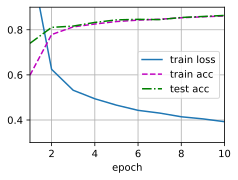

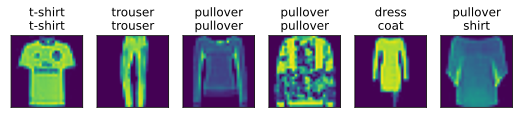

In [ ]:
## The following code has been copied from the textbook for testing purposes
############################################################

# Initialising model parameters
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

num_inputs, num_outputs = 784, 10

num_hiddens = 100

W1 = np.random.normal(scale=0.01, size=(num_inputs, num_hiddens))
b1 = np.zeros(num_hiddens)
W2 = np.random.normal(scale=0.01, size=(num_hiddens, num_outputs))
b2 = np.zeros(num_outputs)
params = [W1, b1, W2, b2]

for param in params:
    param.attach_grad()

# Activation function
def relu(X):
    return np.maximum(X, 0)

# Model and Loss function
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(np.dot(X, W1) + b1)
    return np.dot(H, W2) + b2

loss = gluon.loss.SoftmaxCrossEntropyLoss()

# Training
num_epochs, lr = 10, 0.1
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
              lambda batch_size: d2l.sgd(params, lr, batch_size))

# Testing
d2l.predict_ch3(net, test_iter)

> **Answer:**
>
> The output of the code block above is when the value of `num_hiddens = 100`, and the training loss and train/test accuracy all seem quite comprable to the graph when the value assigned to the hyperparameter was higher (as high as `num_hiddens = 3000`. The only difference is the time taken to fully train the model.
>
> For this reason, I would say that fairly lower values (in the range of 100-500) are sufficient for the hyperparameter since it takes less computational power while providing basically the same results as when the value is much higher.

---
#### 4.2.7: 2
Try adding an additional hidden layer to see how it affects the results.

In [ ]:
num_hiddens = 256
 
W1 = np.random.normal(scale=0.01, size=(num_inputs, num_hiddens))
b1 = np.zeros(num_hiddens)
W2 = np.random.normal(scale=0.01, size=(num_hiddens, num_outputs))
b2 = np.zeros(num_outputs)
W3 = np.random.normal(scale=0.01, size=(num_hiddens, num_outputs))
b3 = np.zeros(num_outputs)
params = [W1, b1, W2, b2, W3, b3]

for param in params:
    param.attach_grad()

# Model
def net(X):
    X = X.reshape((-1, num_inputs))
    H1 = relu(np.dot(X, W1) + b1) 
    H2 = relu(np.dot(H1, W2) + b2)  # Added new hidden layer
    return (np.dot(H2.T, W3) + b3)

# Training
num_epochs, lr = 10, 0.1
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
              lambda batch_size: d2l.sgd(params, lr, batch_size))

# Testing
d2l.predict_ch3(net, test_iter)

---
#### 4.2.7: 3

How does changing the learning rate affect the results of the programme?

> **Answer:**
>
> The learning rate was originally set to be $0.1$. Increasing this to a higher number like $0.5$ leads to the training cycle taking the same amount of time, however it is noticeable that the `Training Loss` falls faster when this lr is increased. 
>
> For the purposes of my testing, it is the case that increasing the learning rate further (to $\geq 0.8$) continues to make the `Training Loss` fall faster and faster, however the `testing_accuracy` falls and becomes less stable (from one epoch to the next). This may be because it is hard to find the minimum loss value since the step size is too large. 

---
### Exercise 4.3.3

Concise implementation of MLP.


---
#### 4.3.3: 2
Try out different activation functions to see which works best.

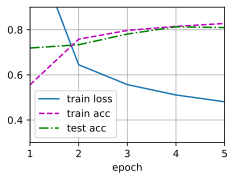

In [ ]:
from mxnet import gluon, init, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

activations = ['relu', 'tanh', 'sigmoid']

for act in activations:
  print('Activation function being used is: {}'.format(act))
  net = nn.Sequential()
  net.add(nn.Dense(256, activation=act), nn.Dense(10))
  net.initialize(init.Normal(sigma=0.01))

  batch_size, lr, num_epochs = 256, 0.3, 5
  loss = gluon.loss.SoftmaxCrossEntropyLoss()
  trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

  train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
  d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)
  plt.show()


> **Answer:**
>
> In general it would appear as though the all the three activation functions I tested (relu, sigmoid, and tanh) performed very similarly; with all the peak test/train accuracies being the same $\approx 0.8$, and the minimum training loss values after 5 epochs also being quite similar $\approx 0.5$.

---
### Exercise 4.5.6
Weight Decay

---
#### 4.5.6: 1
Tinker with the value of $\lambda$ for the weight decay method of model regularisation, and plot training and testing accuracy as a function of $\lambda$. What do you observe?

> *Cannot figure out how to complete this*

---
### Exercise 4.6.7
Dropout.

---
#### 4.6.7: 4
Why is dropout typically not used at test time?

**Answer:**
> The main reason I think this would be needed is because nodes are dropped out at random during each iteration of the training process, and so trying to use dropout during testing may result in some of the more "important" nodes being left unused. This may then worsen the training outputs and also result in inconsistent outputs during the testing phase.

--- 
### Exercise 4.7.6
Forward Propagation, Backward Propagation, and Computational Graphs

---
---
# DL Computation and (Modern) Convnets
(Book chapters: 5-7)

The exercises to be done in this section:
* 5.1.6: 2
* 5.2.5: 4
* 5.3.3: 1
* 6.1.6: 1
* 6.3.4: 2
* 6.4.5: 1
* 6.5.5: 1
* 6.6.4: 1
* 7.5.8: 2
* 7.6.6: 1

---
## Chapter 5: Deep Learning Computation

---
### Exercise 5.1.6
Layers and Blocks.

---
#### 5.1.6: 2
Implement a parallel block: a block which takes two blocks as arguments (`net1` and `net2`) and returns the concatenated output of both networks in the forward propagation.

In [ ]:
from mxnet.gluon import nn

class ParallelBlock(nn.Block):
  
  def __init__(self, **kwargs):
    # Using the Block class to perform initialisation
    super().__init__(**kwargs)
    self.block = nn.Dense(25, activation='relu')
  
  def forward(self, net1, net2):
    # Calculate the 'block' representation of the two blocks provided
    net1, net2 = self.block(net1), self.block(net2)

    # Return the concatenation of the two blocks
    return np.concatenate([net1, net2])


In [ ]:
# Initialise two "blocks"
net1, net2 = np.random.uniform(size=(2,10)), np.random.uniform(size=(2,10))

# Implementation of ParallelBlock
par_net = ParallelBlock()
par_net.initialize()
par_forward = par_net(net1, net2)

par_forward, par_forward.shape

(array([[-0.        ,  0.06256887, -0.        ,  0.08311971,  0.04429356,
          0.04273162, -0.        ,  0.05676552,  0.03403755,  0.04845526,
         -0.        ,  0.01390576,  0.01912886,  0.04930818, -0.        ,
         -0.        ,  0.1032606 , -0.        ,  0.07182632,  0.02089401,
         -0.        , -0.        ,  0.03707811, -0.        , -0.        ],
        [-0.        ,  0.00589727, -0.        , -0.        ,  0.00400568,
          0.03714854,  0.00397872,  0.08402198, -0.        , -0.        ,
          0.01383733,  0.08823384, -0.        ,  0.07377084, -0.        ,
         -0.        ,  0.04941053, -0.        ,  0.06128994,  0.00427239,
         -0.        , -0.        ,  0.02152859, -0.        , -0.        ],
        [-0.        ,  0.08000347, -0.        , -0.        ,  0.06089069,
          0.05492118,  0.04558422, -0.        , -0.        ,  0.05335779,
         -0.        ,  0.05259166, -0.        ,  0.08792481, -0.        ,
          0.01476038,  0.15285762, -

---
### Exercise 5.2.5
Parameter Management

---
#### 5.2.5: 4
Why is sharing parameters a good idea?

**Answer:**
> As stated in the book, when parameters are shared between layers, they are not just two equal sets of parameters but they are infact the same exact object in memory.
>
> From what I can tell, the biggest advantage here would be memory management since there is only a single tensor on the disk storing the values of the various parameters. 

---
### Exercise 5.3.3
Deferred Initialisation

---
#### 5.3.3: 1
Do you get immediate initialisation if you specify the input dimensions to the first layer but not to the subsequent layers?

In [ ]:
from mxnet.gluon import nn

input_size = 25

def get_net(input=input_size):
  net = nn.Sequential()
  # Specify input size for first layer
  net.add(nn.Dense(256, in_units=input))
  # Don't specify input sizes
  net.add(nn.Dense(128))
  net.add(nn.Dense(10))
  return net

net = get_net()

net.collect_params()

sequential2_ (
  Parameter dense6_weight (shape=(256, 25), dtype=float32)
  Parameter dense6_bias (shape=(256,), dtype=float32)
  Parameter dense7_weight (shape=(128, -1), dtype=float32)
  Parameter dense7_bias (shape=(128,), dtype=float32)
  Parameter dense8_weight (shape=(10, -1), dtype=float32)
  Parameter dense8_bias (shape=(10,), dtype=float32)
)

**Answer:**
> In the case above, by setting and specifying `input_size = 25` for the first layer leads to immediate initialisation of the *first layer* ***only***. The rest of the layers seem to have their input size set to `-1` which implies that initlisation has been deferred.

---
## Chapter 6: Convolutional Neural Networks

---
### Exercise 6.1.6
From Fully-Connected Layers to Convolutions

---
#### 6.1.6: 1
Assume that the size of the convolution kernel is $\Delta = 0$. Show that in this case the convolution kernel implements an MLP independently for each set of channels.

**Answer:**
> Using the *Principle of Locality* as a basis, we know that given the following equation
$$
  \mathbf{[H]}_{i, j} = u + \sum_{a=-\Delta}^{\Delta} \sum_{b=-\Delta}^{\Delta} \mathbf{[V]}_{a, b} \mathbf{[X]}_{i+a, j+b}
$$ 
setting $\Delta = 0$ would mean that $\mathbf{[V]}_{a, b}$ is set to $0$ for all pixels, and the only pixel that is taken into consideration is the one at position $(i, j)$. This is exactly the behaviour that is seen in MLPs -- looking at only one pixel at a time.

---
### Exercise 6.3.4
Padding and Stride

---
#### 6.3.4: 2
Try other padding and stride combinations on the experiments in this section.

In [ ]:
'''
  This function is copied exactly from the textbook
'''
def comp_conv2d(conv2d, X):
    conv2d.initialize()
    # Here (1, 1) indicates that the batch size and the number of channels
    # are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Exclude the first two dimensions that do not interest us: examples and
    # channels
    return Y.reshape(Y.shape[2:])

In [ ]:
inp_shape = (8, 8)
X = np.random.uniform(size=inp_shape)

# Define Convolutional layer
conv2d_0 = nn.Conv2D(1, kernel_size=(5, 3), padding=(2, 1))

# Compute output
out_shape_0 = comp_conv2d(conv2d_0, X).shape
print('Odd kernel shapes (5, 3) with non-uniform padding (2, 1).\nInput shape: {}, Output shape: {}\n'.
      format(inp_shape, out_shape_0))


# Using padding=(2,2)
conv2d_1 = nn.Conv2D(1, kernel_size=(5, 3), padding=(2,2))
out_shape_1 = comp_conv2d(conv2d_1, X).shape
print('Odd kernel shapes (5, 3) with uniform padding (2, 2).\nInput shape: {}, Output shape: {}\n'.
      format(inp_shape, out_shape_1))

## Uniform padding with uniform stride size
conv2d_u_u = nn.Conv2D(1, kernel_size=3, padding=1, strides=2)
out_shape_u_u = comp_conv2d(conv2d_u_u, X).shape
print('Uniform kernel_size=3) with uniform padding=1 and uniform stride=2.\nInput shape: {}, Output shape: {}\n'.
      format(inp_shape, out_shape_u_u))

## Uniform padding with non-uniform stride size
conv2d_u_nu = nn.Conv2D(1, kernel_size=3, padding=1, strides=(2, 1))
out_shape_u_nu = comp_conv2d(conv2d_u_nu, X).shape
print('Uniform kernel_size=3 with uniform padding=1 and non-uniform stride (2, 1).\nInput shape: {}, Output shape: {}\n'.
      format(inp_shape, out_shape_u_nu))

Odd kernel shapes (5, 3) with non-uniform padding (2, 1).
Input shape: (8, 8), Output shape: (8, 8)

Odd kernel shapes (5, 3) with uniform padding (2, 2).
Input shape: (8, 8), Output shape: (8, 10)

Uniform kernel_size=3) with uniform padding=1 and uniform stride=2.
Input shape: (8, 8), Output shape: (4, 4)

Uniform kernel_size=3 with uniform padding=1 and non-uniform stride (2, 1).
Input shape: (8, 8), Output shape: (4, 8)



**Answer:**
> When using a non-uniform odd `kernel_size` and a non-uniform `padding`, the result matches what is described in the textbook, i.e. the output shape remains unchanged from the input. However, if the `padding` is uniform, then the output shape is unlike the input.
>
> When using uniform `kernel_size=3` with a uniform `padding=1`, a uniform `srides=2` results in an ouput which is half the size of the input. Again, this matches the description provided in the book. If a non-uniform `strides=(2,1)` is used, then the shape of the output is only halved in the dimension corresponding to that where the stride $\neq$ 1.

---
### Exercise 6.4.5
Multiple Input and Multiple Output Channels

---
#### 6.4.5: 1
Assume two convolution kernels $k_{1}, k_{2}$ with no non-linearity in between.
1.  Prove that the result of the operation can be expressed by a single convolution.
2.  What is the dimensionality of the equivalent single convolution?
3.  Is the converse true?

**Answer:**
> 1.  First, let
> \begin{aligned}
  \mathbf{K} &= [k_{1}] [k_{2}] \\
  \mathbf{U} &= u_{2} + \sum_{a}\sum_{b} [k_2]_{a,b} \cdot u_{1}
  \end{aligned}
  Then,
  \begin{aligned}
  \mathbf{[H]}_{i, j} &= u_{2} + \sum_{a}\sum_{b} [k_{2}]_{a,b} \Big(u_{1} + \sum_{a}\sum_{b} [k_{1}]_{a,b}\mathbf{[X]}_{i+a, j+b} \Big) \\
  &= u_{2} + \sum_{a}\sum_{b}[k_{2}]_{a, b}\cdot u_{1} + \sum_{a}\sum_{b}[k_2]_{a,b}[k_1]_{a,b}\mathbf{[X]}_{i+a, j+b} \\
  &= \mathbf{U}\; + \sum_{a}\sum_{b}\mathbf{[K]}_{a, b}\mathbf{[X]}_{i+a, j+b}
  \end{aligned}
>
> $\quad\quad$ Where $\mathbf{[H]}_{i, j}$ is the hidden representation at location $(i, j)$.
>
> 2.  The dimensionality of the equivalent single convolution will be the same as the dimensionality of $k_{2}$.
>
> 3.  Yes it seems intuitively that the converse would be true.

---
### Exercise 6.5.5
Pooling

---
#### 6.5.5: 1
Can you implement average pooling as a special case of a convolution layer? If so, do it.



---
**Answer:**
> Yes, average pooling can be implemented as a special case of a convolutional layer. This would require for example, that the kernel size to be $2 \times 2$, with values of $0.25$. Then, calculating the cross-correlation will yield in average pooling behaviour.
>
> In general, this can be carried out with any kernel of size $N \times N$, as long as the weights of each position in the kernel are $\frac{1}{N^{2}}$ and $N > 1$.


In [ ]:
X = np.array([[0,1,2], [3,4,5], [6,7,8]], dtype=np.float32)
kernel = np.array([[0.25, 0.25], [0.25, 0.25]])

d2l.corr2d(X, kernel)

array([[2., 3.],
       [5., 6.]])

> The output aove is correct because the average of $0, 1, 3, 4$ is indeed $2$, the average of $1, 2, 4, 5$ is indeed $3$, etc.

---
### Exercise 6.6.4
Convolutional Neural Networks

---
#### 6.6.4: 1
Replace the average pooling with maximum pooling. What happens?

loss 0.410, train acc 0.850, test acc 0.820
16024.9 examples/sec on gpu(0)


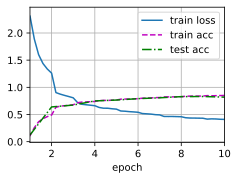

In [ ]:
'''
The following code is copied from the textbook.
  The only change made is that the pooling layers have been changed
  from AvgPool2D to MaxPool2D.
'''

# Create network structure
net = nn.Sequential()
net.add(
    nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
    nn.MaxPool2D(pool_size=2, strides=2),
    nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
    nn.MaxPool2D(pool_size=2, strides=2),
    # `Dense` will transform an input of the shape (batch size, number of
    # channels, height, width) into an input of the shape (batch size,
    # number of channels * height * width) automatically by default
    nn.Dense(120, activation='sigmoid'), nn.Dense(84, activation='sigmoid'),
    nn.Dense(10))

# Generate training and testing data
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if not device:  # Query the first device where the first parameter is on
        device = list(net.collect_params().values())[0].list_ctx()[0]
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X, y = X.as_in_ctx(device), y.as_in_ctx(device)
        metric.add(d2l.accuracy(net(X), y), y.size)
    return metric[0] / metric[1]

# To train model, and check test/train accuracy
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    net.initialize(force_reinit=True, ctx=device, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            # Here is the major difference from `d2l.train_epoch_ch3`
            X, y = X.as_in_ctx(device), y.as_in_ctx(device)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# Train and test model
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**Answer:**
> The results are not vastly different from those seen in the textbook (where they used `AvgPool2D()` instead of `MaxPool2D()`. But there are slight differences, and the one aspect in which using MaxPooling has helped in this one try is that the `loss` value is smaller in my test than what is seen in the textbook (Mine: $0.410$ vs. Theirs: $0.473$).

---
## Chapter 7: Modern Convolutional Neural Networks

---
### Exercise 7.5.8
Batch Normalisation

---
#### 7.5.8: 2
Compare the learning rates for LeNet with and without batch normalisation.
  1.  Plot the increase in training and test accuracy.
  2.  How large can you make the learning rate?

**Answer:**
> 1.  The two NNs will be run on learning rates from the following list: $[0.5, 1.0, 5.0, 10.0, 25.0]$.

In [ ]:
# Define network with Batch Normalisation
'''
This network definition is copied from the textbook
'''
net_bn = nn.Sequential()
net_bn.add(nn.Conv2D(6, kernel_size=5), nn.BatchNorm(), nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2), nn.Conv2D(16, kernel_size=5),
        nn.BatchNorm(), nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2), nn.Dense(120), nn.BatchNorm(),
        nn.Activation('sigmoid'), nn.Dense(84), nn.BatchNorm(),
        nn.Activation('sigmoid'), nn.Dense(10))

# Define network without Batch Normalisation
net_no_bn = nn.Sequential()
net_no_bn.add(nn.Conv2D(6, kernel_size=5), nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2), nn.Conv2D(16, kernel_size=5),
        nn.Activation('sigmoid'),
        nn.MaxPool2D(pool_size=2, strides=2), nn.Dense(120),
        nn.Activation('sigmoid'), nn.Dense(84),
        nn.Activation('sigmoid'), nn.Dense(10))

# Using smaller num_epoch and batch_size to increase speed of training
num_epochs, batch_size = 6, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)


> First, we test the performance of `net_no_bn` (without *Batch normalisation*).

loss 0.536, train acc 0.790, test acc 0.797
9906.5 examples/sec on gpu(0)


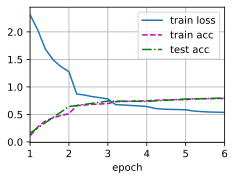

In [ ]:
lr = 0.5
d2l.train_ch6(net_no_bn, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.462, train acc 0.825, test acc 0.847
9749.9 examples/sec on gpu(0)


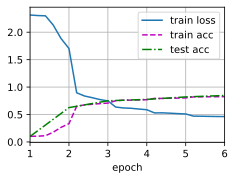

In [ ]:
lr = 1.0
d2l.train_ch6(net_no_bn, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())


loss 0.686, train acc 0.740, test acc 0.726
9931.0 examples/sec on gpu(0)


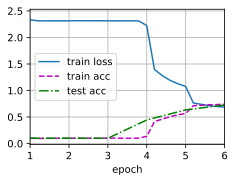

In [ ]:
lr = 5.0
d2l.train_ch6(net_no_bn, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 2.341, train acc 0.099, test acc 0.100
9955.5 examples/sec on gpu(0)


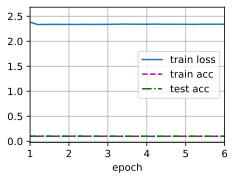

In [ ]:
lr = 10.0
d2l.train_ch6(net_no_bn, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 3.287, train acc 0.099, test acc 0.100
9878.6 examples/sec on gpu(0)


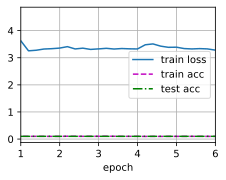

In [ ]:
lr = 25.0
d2l.train_ch6(net_no_bn, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

> Then, we test the performance of `net_bn` (with *Batch normalisation*).

loss 0.276, train acc 0.901, test acc 0.883
9439.8 examples/sec on gpu(0)


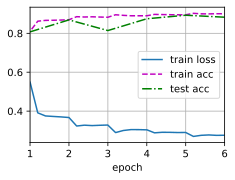

In [ ]:
lr = 0.5
d2l.train_ch6(net_bn, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.278, train acc 0.898, test acc 0.891
9439.4 examples/sec on gpu(0)


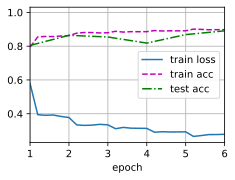

In [ ]:
lr = 1.0
d2l.train_ch6(net_bn, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.288, train acc 0.894, test acc 0.889
9413.2 examples/sec on gpu(0)


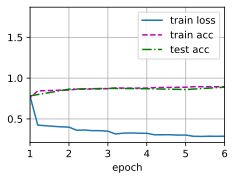

In [ ]:
lr = 5.0
d2l.train_ch6(net_bn, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.316, train acc 0.883, test acc 0.870
9433.4 examples/sec on gpu(0)


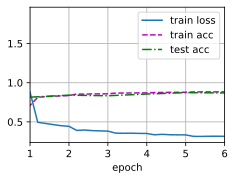

In [ ]:
lr = 10.0
d2l.train_ch6(net_bn, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.450, train acc 0.846, test acc 0.847
9441.2 examples/sec on gpu(0)


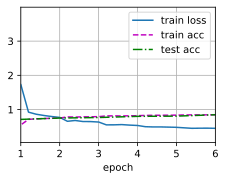

In [ ]:
lr = 25.0
d2l.train_ch6(net_bn, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

> 2.  For the network without Batch normalisation, the decrease in loss through the epochs was imperceptible for `lr > 5`. So although you can set `lr` to be higher than that, it will not lead to much use in terms of training.
> For the network with Batch normalisation on the other hand, it seems as though the decrease in loss is present through the epochs even with large values such as `lr = 25`. However, these loss values are much higher than if the learning rate value was saller, so it still holds keeping learning rates smaller will yield better results.

---
### Exercise 7.6.6
Residual Networks (ResNet)

---
#### 7.6.6: 1
What are the major differences between the Inception block and the residual block? After removing some paths in the Inception block, how are they related to each other?

**Answer:**
> Some of the major differences:
> 1.  A residual module only has 2 parallel pathways whereas the Inception block has 4.
> 2.  A residual module carries out a batch norm after each convolution on the input whereas there is no batch normalisation going on in the Inception block.
> 3. A residual block **adds** the input $\mathbf{x}$ (with or without the $1 \times 1$ convolution) to the ouput of the 2 convolution operations, whereas the Inception block **concatenates** the outputs from its 4 paths.
>
> Beyond this, if the path with the $5 \times 5$ convolution layer and the path with the $3 \times 3$ MaxPool layer followed by a $1 \times 1$ convolution operation, are both removed from the Inception block, then the remaining architecture will closely resemble a residual module without any batch norm.

---
---
# (Modern) Recurrent Neural Networks

(Book chapters 8 and 9)

The exercises to be done in this section:
*  8.1.5: 1
*  8.4.6: 3
*  8.5.8: 4
*  9.1.5: 3

---
### Exercise 8.1.5
Sequence Models

---
#### 8.1.5: 1
Improve the model in the experiment of this section.
1.  Incorporate more than the last 4 observations. How many do you really need?
2.  How may past observations would you need if there was no noise?
3.  Can you incorporate older observations while keeping the total number of features constant? Does this improve accuracy?
4.  Change the neural network architecture and evaluate the performance.

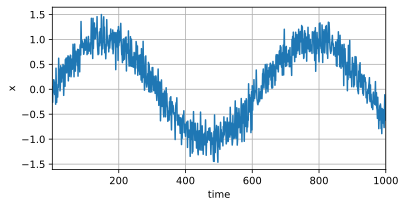

In [ ]:
'''
The following code is copied from the textbook.
'''
T = 1000  # Generate a total of 1000 points
time = np.arange(1, T + 1, dtype=np.float32)
x = np.sin(0.01 * time) + np.random.normal(0, 0.2, (T,))
# x = np.sin(0.01 * time)
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

epoch 1, loss: 0.054793
epoch 2, loss: 0.026731
epoch 3, loss: 0.024755
epoch 4, loss: 0.044050
epoch 5, loss: 0.027209


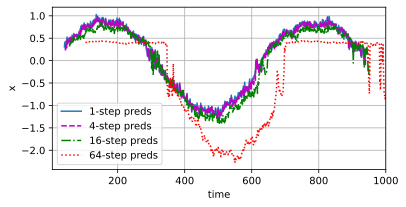

In [ ]:
'''
The following code is copied from the textbook 
The following things are changed for reasons of answering the questions:
- tau
- features
- get_net()
'''
tau = 40
features = np.zeros((T - tau, tau))
a = list()
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

# A simple MLP
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(10, activation='relu'), 
            nn.Dense(25, activation='relu'),
            nn.Dense(25, activation='relu'),
            nn.Dense(25, activation='relu'),
            nn.Dense(10),
            nn.Dense(1))
    net.initialize(init.Xavier())
    return net

# Square loss
loss = gluon.loss.L2Loss()

def train(net, train_iter, loss, epochs, lr):
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    for epoch in range(epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

max_steps = 64

features = np.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].asnumpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds'
                 for i in steps], xlim=[5, 1000], figsize=(6, 3))


**Answer:**
> 1.  It appears that setting $\tau \geqslant 40$ results in 1-step, 4-step, and 16-step preds which are all extremely close to the actual distribution. For the 64-step preds, setting $\tau \approx 100$ yields quite accurate predictions, but the preformance of that is quite bad if fewer past observations are made.
>
> 2.  When noise is removed in $x$, then setting $\tau \geqslant 20$ is sufficient to obtain extremely accurate 1-step, 4-step, and 16-step preds. For accurate 64-step preds, setting to $\tau \approx 80$ is the minimum value required. Anything less than this does not yield in proper predictions.
>
> 3.  This can be done, but it does not hep improve accuracy of the output.
>
> 4.  Adding more fully-connected layers in the network which all also have ReLu activation can be visually seen to help prediction accuracy as  n-step preds are quite close to the actual distribution even with lower values of $\tau$.

---
### Exercise 8.4.6
Recurrent Neural Networks

---
#### 8.4.6: 3
What happens to the gradient if you backpropagate through a long sequence?

**Answer:**
> For a sequence of length $T$, we compute the gradients over these $T$ time steps in an iteration, which results in a chain of matrix-products with length $O(T)$ during backpropagation. 

---
### Exercise 8.5.8
Implementation of RNNs from scratch.

---
#### 8.5.8: 4
Run the code in this section without gradient clipping. What happens?

In [ ]:
'''
All of the definitions in this cell are copied from the textbook
'''
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return np.random.normal(scale=0.01, size=shape, ctx=device)

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = np.zeros(num_hiddens, ctx=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = np.zeros(num_outputs, ctx=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.attach_grad()
    return params

def init_rnn_state(batch_size, num_hiddens, device):
    return (np.zeros((batch_size, num_hiddens), ctx=device),)

def rnn(inputs, state, params):
    # Shape of `inputs`: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = np.tanh(np.dot(X, W_xh) + np.dot(H, W_hh) + b_h)
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H,)

X = np.arange(10).reshape((2, 5))

num_hiddens = 512
net = d2l.RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.as_in_context(d2l.try_gpu()), state)

perplexity 1.0, 18982.5 tokens/sec on gpu(0)
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


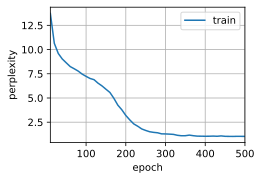

In [ ]:
'''
The following function definition is copied from the textbook.
- A call to grad_clipping() has been removed.
'''

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a model within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], ctx=device)
        else:
            for s in state:
                s.detach()
        y = Y.T.reshape(-1)
        X, y = X.as_in_ctx(device), y.as_in_ctx(device)
        with autograd.record():
            y_hat, state = net(X, state)
            l = loss(y_hat, y).mean()
        l.backward()
        updater(batch_size=1)  # Since the `mean` function has been invoked
        metric.add(l * y.size, y.size)
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

**Answer:**
> Compared to the results seen in the textbook, the perplexity I obtained is lower (mine: $1.0$ vs theirs: $1.4$). Additionally, the number of tokens/sec computed in my run is significantly lower than theirs. This however should be as a result of differing hardware.
>
> Not many differences were noted, and I suppose this is because their implementation of `grad_clipping()` used too high a value of $\theta$. Hence resulting in quite a normal output.

---
### Exercise 9.1.5
Gated Recurrent Units (GRUs)

---
#### 9.1.5: 3
Compare runtime, perplexity, and the output strings for `rnn.RNN` and `rnn.GRU` implementations with each other.

In [ ]:
'''
The following function definitions are copied from the textbook.
'''
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return np.random.normal(scale=0.01, size=shape, ctx=device)

    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal(
                (num_hiddens, num_hiddens)), np.zeros(num_hiddens,
                                                      ctx=device))

    W_xz, W_hz, b_z = three()  # Update gate parameters
    W_xr, W_hr, b_r = three()  # Reset gate parameters
    W_xh, W_hh, b_h = three()  # Candidate hidden state parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = np.zeros(num_outputs, ctx=device)
    # Attach gradients
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.attach_grad()
    return params

def init_gru_state(batch_size, num_hiddens, device):
    return (np.zeros(shape=(batch_size, num_hiddens), ctx=device),)

def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = npx.sigmoid(np.dot(X, W_xz) + np.dot(H, W_hz) + b_z)
        R = npx.sigmoid(np.dot(X, W_xr) + np.dot(H, W_hr) + b_r)
        H_tilda = np.tanh(np.dot(X, W_xh) + np.dot(R * H, W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H,)


perplexity 1.2, 12649.9 tokens/sec on gpu(0)
time traveller come time soin to exer oon the grove ollit seemly
traveller atwerth urhatteran t of the bron thied co to the 


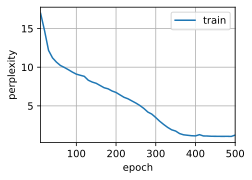

In [ ]:
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

**Answer:**
> Running the `rnn.GRU` network, we see that the perplexity is higher, the runtime (looking at tokens/sec) is lower, and the string outputted is less sensible -- contains significantly fewer "real" words -- when compared to the output of my `rnn.RNN` from my exercise 8.5.8: 4. (Number of epochs, training data size, and learning reate were all help constant.)
>
> Essentially, the performance of the `GRU` is worse in every measure.

---
---
# Generative Adversarial Networks
(Book chapter 17)

Exercised to be done in this chapter:
*  17.1.6
*  17.2.6: 1
*  Follow 17.2 to generate new pokemons

---
### Exercise 17.1.6
Generative Adversarial Networks

---
Does an equilibrium exist where the generator wins, *i.e.* the fiscriminator ends up unable to distinguish the two distributions on finite samples?

**Answer:**
> Yes an equilibrium as such does exist. This is especially the case if the network, as described in the book, does not update the discriminator through the process to "inform" it of the fact that it has made a misclassification. Then eventually the generator (depending on its complexity and capability) can then reach a point where the fake data it generates is basically as good as the real data that the discriminator was trained on.

---
### Exercise 17.2.6
Deep Convolutional GANs (DCGANs)

---
#### 17.2.6: 1
What will happen if we use standard ReLU activation rather than leaky ReLU?

**Answer:**
> Then there is a much higher chance of getting stuck in one local area on the overall distribution if the value produced by the neurons in it is negative since the activation will always result in a $0$. Using leaky ReLU means that the discriminator will continue to perform even if some (or most) of its neurons output negative values for the incoming data.

---
### 17.2: Generate new pokemons

In [ ]:
'''
All the function definitions and variable asignments in the following cell
have been copied directly from the textbook.
'''
# Download dataset
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = gluon.data.vision.datasets.ImageFolderDataset(data_dir)

# Resize images to a more manageable resolution
batch_size = 256
transformer = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(64),
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize(0.5, 0.5)])
data_iter = gluon.data.DataLoader(pokemon.transform_first(transformer),
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=d2l.get_dataloader_workers())

# Define Generator block and corresponding network
class G_block(nn.Block):
    def __init__(self, channels, kernel_size=4, strides=2, padding=1,
                 **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.Conv2DTranspose(channels, kernel_size, strides,
                                               padding, use_bias=False)
        self.batch_norm = nn.BatchNorm()
        self.activation = nn.Activation('relu')

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

n_G = 64
net_G = nn.Sequential()
net_G.add(G_block(n_G * 8, strides=1, padding=0),  # Output: (64 * 8, 4, 4)
          G_block(n_G * 4),  # Output: (64 * 4, 8, 8)
          G_block(n_G * 2),  # Output: (64 * 2, 16, 16)
          G_block(n_G),  # Output: (64, 32, 32)
          nn.Conv2DTranspose(3, kernel_size=4, strides=2, padding=1,
                             use_bias=False,
                             activation='tanh'))  # Output: (3, 64, 64)

# Define Discriminator block and corresponding network
class D_block(nn.Block):
    def __init__(self, channels, kernel_size=4, strides=2, padding=1,
                 alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2D(channels, kernel_size, strides, padding,
                                use_bias=False)
        self.batch_norm = nn.BatchNorm()
        self.activation = nn.LeakyReLU(alpha)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

n_D = 64
net_D = nn.Sequential()
net_D.add(D_block(n_D),  # Output: (64, 32, 32)
          D_block(n_D * 2),  # Output: (64 * 2, 16, 16)
          D_block(n_D * 4),  # Output: (64 * 4, 8, 8)
          D_block(n_D * 8),  # Output: (64 * 8, 4, 4)
          nn.Conv2D(1, kernel_size=4, use_bias=False))  # Output: (1, 1, 1)

# Define training function
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = gluon.loss.SigmoidBCELoss()
    net_D.initialize(init=init.Normal(0.02), force_reinit=True, ctx=device)
    net_G.initialize(init=init.Normal(0.02), force_reinit=True, ctx=device)
    trainer_hp = {'learning_rate': lr, 'beta1': 0.5}
    trainer_D = gluon.Trainer(net_D.collect_params(), 'adam', trainer_hp)
    trainer_G = gluon.Trainer(net_G.collect_params(), 'adam', trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = np.random.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.as_in_ctx(device), Z.as_in_ctx(device),
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = np.random.normal(0, 1, size=(21, latent_dim, 1, 1), ctx=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).transpose(0, 2, 3, 1) / 2 + 0.5
        imgs = np.concatenate([
            np.concatenate([fake_x[i * 7 + j] for j in range(7)], axis=1)
            for i in range(len(fake_x) // 7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs.asnumpy())
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')


loss_D 0.005, loss_G 8.080, 317.4 examples/sec on gpu(0)


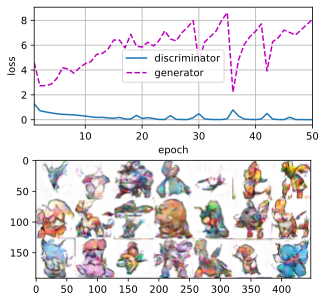

In [ ]:
'''
Increase num_epochs to 100 in order to obtain better results.
'''
latent_dim, lr, num_epochs = 100, 0.005, 50
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

---
---
# Optimisation Algorithms
(Book chapter 11)

Exercises to do in this section:
*  11.1.4: 1
*  11.2.5: 3
*  11.3.5: 3
*  11.4.6: 1
*  11.5.7: 3
*  11.6.5: 1
*  11.10.5: 3

---
### Exercise 11.1.4: 1
#### Optimisation and Deep Learning INCOMPLETE

Consider a simple MLP with a signle hidden layer of, say, $d$ dimensions in the hidden layer and a single output. Show thatfor any local minimum, there are at least $d!$ equivalent solutions that behave identically.

> *Do not know how to prove this.*

---
### Exercise 11.2.5: 3
#### Convexity

Given two convex functions $f$ and $g$, prove that $\text{max}(f, g)$ is convex too. Prove that $\text{min}(f, g)$ is not convex.

**Answer:**
> Let $m = \text{max}(f, g)$. In addition, we know that a given function is convex **iff** the area above its graph is convex. 
> Then, we also know that $m$ is the intersection of the area above the graphs of the functions $f$ and $g$. And the intesection of two convex sets is also a convex set.
> $$ \therefore m \text{ is a convex set.} $$
>
> Let $h = \text{min}(f, g) \Leftrightarrow h = f \cup g$. Then, let 
\begin{aligned}
  f &= (x + 1)^2 \\ g &= (x-1)^2
\end{aligned} (both functions are convex).
>
> Then, for $x, x' \in \mathcal{X}$ and $\lambda \in [0, 1]$, if $h \in \mathcal{X}$ holds then the following equality must hold (where $\mathcal{X}$ is a convex set).
>
>$$ h(\lambda x + (1-\lambda) x') \leqslant \lambda(h(x)) + (1-\lambda)(h(x'))$$
>
> Let $\lambda = 0.5, x = -1, x' = 1$.
>
> \begin{aligned}
  h(\frac{1}{2} \cdot -1 + \frac{1}{2} \cdot 1) &\leqslant \frac{1}{2}\cdot h(-1) + \frac{1}{2} \cdot h(1) \\
  h(0) &\leqslant \frac{1}{2} \big( h(-1) + h(1) \big) \\
  \text{min}\big(f(0), g(0)\big) &\leqslant \frac{1}{2} \big( \text{min}\big(f(-1), g(-1)\big) + \text{min}\big(f(1), g(1)\big) \big) \\
  1 &\leqslant \frac{1}{2} \big( 0 + 0 \big) \\
  1 &\not\leqslant 0
\end{aligned}
>
> Therefore $h$ is not convex.

---
### Exercise 11.3.5: 3
#### Gradient Descent

Design an objective function defined on $\mathbb{R}^2$ where gradient descent is exceedingly slow.

**Answer:**
> $$f(x) = \frac{1}{10000}x^{2}$$ for $x \in \mathbb{R}$.
> 
> If, like in the code in the textbook, your computation of gradient descent starts at $x=10$, reaching the minima of this function will take a lot of time since tuning the learning rate will be difficult. This is as a direct result of the fact that the curve becomes extremely flat near the global minimum.

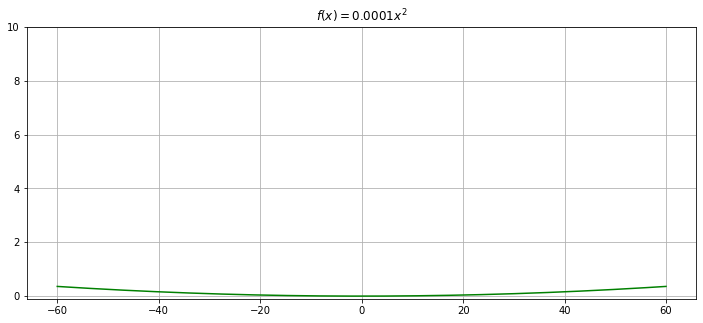

In [ ]:
def objective_func(x):
  return (1 / 10000) * (x ** 2)

x = np.linspace(-60, 60, num=1000, endpoint=True)

function = [objective_func(data) for data in x]

plt.figure(figsize=(12, 5))
plt.plot(x, function, 'g')
plt.title('$f(x) = 0.0001 x^{2}$')
plt.grid()
plt.ylim(-0.1, 10)
plt.show()


---
### Exercise 11.4.6: 1
#### Stochastic Gradient Descent

Experiment with different learning rate schedules for stochastic gradient descent and with different numbers of iterations. In particular, plot the distance from the optimal solution $(0,0)$ as a function of the number of iterations.

epoch 500, x1: 0.011056, x2: 0.007500


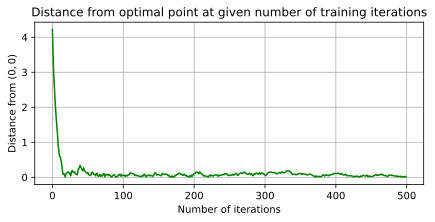

In [ ]:
def get_x_y(results, optim_x=0, optim_y=0):
  results.pop(0)

  iterations = np.arange(len(results))
  distance = np.zeros(len(results))

  for i, (x, y) in enumerate(results):
    distance[i] = np.sqrt(((optim_x - x) ** 2) + ((optim_y - y) ** 2))
  
  return iterations, distance



'''
The following code was copied from the textbook.
'''
def f(x1, x2):  # Objective function
    return x1**2 + 2 * x2**2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += np.random.normal(0.0, 1, (1,))
    g2 += np.random.normal(0.0, 1, (1,))
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

def polynomial_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return (1 + 0.1 * t)**(-0.5)

eta = 0.1
t = 1
lr = polynomial_lr  # Constant learning rate
results = d2l.train_2d(sgd, steps=500, f_grad=f_grad)

iterations, distance = get_x_y(results)

plt.figure(figsize=(7,3))
plt.plot(iterations, distance, 'g')
plt.title('Distance from optimal point at given number of training iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Distance from $(0, 0)$')
plt.grid()
plt.show()

---
### Exercise 11.5.7: 3 INCOMPLETE
#### Minibatch SGD

Compare minibatch stochastic gradient descent with a variant that actually samples with replacement from the training set. What happens?

> *Incomplete because I cannot figure out how to reshuffle the iterator.*

---
### Exercise 11.6.5: 1
#### Momentum

Use other combinations of momentum hyperparameters and learning rates and observe and analyse the different experimental results.

loss: 0.245, 0.086 sec/epoch


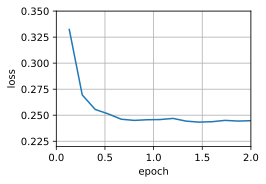

In [ ]:
'''
The following function definitions are copied from the textbook.
'''
def init_momentum_states(feature_dim):
    v_w = np.zeros((feature_dim, 1))
    v_b = np.zeros(1)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v[:] = hyperparams['momentum'] * v + p.grad
        p[:] -= hyperparams['lr'] * v

def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim), {
        'lr': lr,
        'momentum': momentum}, data_iter, feature_dim, num_epochs)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

loss: 0.265, 0.086 sec/epoch


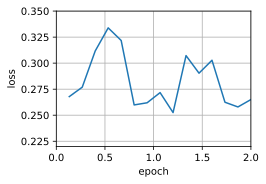

In [ ]:
train_momentum(0.2, 0.5)

**Answer:**
> Increasing the learning rate from 0.02 to 0.2 caused the process to fail to converge. Increasing the number of epochs would likely help, but the process is still expected to take an immense amount of time.

loss: 0.244, 0.088 sec/epoch


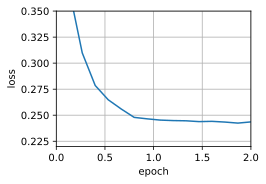

In [ ]:
train_momentum(0.02, 0.25)

> However, leaving `lr = 0.02` and halving the momentum instead, we can see that we obtain a much smoother learning curve but one which appears to take longer to converge.

loss: 0.244, 0.087 sec/epoch


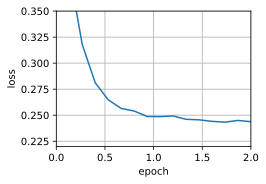

In [ ]:
train_momentum(0.02, 0.1)

> Reducing the momentum further results in a learning curve that is still smooth, but one which takes *even longer* to converge.

---
### Exercise 11.10.5: 3
#### Adam

Why do you need to reduce the learning rate $\eta$ as you converge?

**Answer:**
> The benefit of this practice is that as you approach the global minimum of your loss function, a smaller learning rate will result in smaller steps being taken with each iteration. This drastically reduces the change of overshooting and completely missing the minimum as you approach it.
> 
> In general, this practice does a much better job of ensuring convergence.

---
---
# Computer Vision

---
### Exercsie 1
Deconvolution (fractionally strided convolution) layer is used to increase the spatial size of feature maps of a convnet. Briefly explain how deconvolution works.

**Answer:**
> A deconvolutional layer inside a network does the job of upsampling from a low resolution representation inside a network (after the information having traversed through a number of convolutional and pooling layers) back to a higher resolution for output.
>
> The specific procedure of this layer involves performing a convolution (unlike the name suggests) with added padding around the output in order to obtain information from inner low-resolution layers and map them onto more pixels to generate a higher resolution image.

---
### Exercise 2
Deconvolution layer can lead to checkerboard artefact. Briefly explain what is meant by checkerboard artefact and how it can be overcome.

**Answer:**
> The checkerboard artifact is a phenomenon wherein the upsampled image (in order to create a larger, higher resolution output) that a Convnet outputs contains, in a checkerboard fashion, square areas with intesified (high-frequency) blocks of colour. This is caused specifically as a result of the overlap between the kernel if its stride is uneven, resulting in some areas having compounded frequencies. This can cause the resulting image to look unnatural/corrupted.
>
> An intuitive way to solve this, as discussed [Odena, et al. (2016)](https://distill.pub/2016/deconv-checkerboard/), is either to make sure that you use an even stride which is divisible by your kernel, or to simply resize the image you are to a larger image using a linear transformation technique such as nearest-neighbour interpolation, and then perform the upsampling convolution.

---
### Exercise 3
How do residual connections counter the potential problems of having many layers in a network? Briefly explain.

**Answer:**
> Backpropagating with the presense of non-linear activation functions has historically caused a problem on vanishing gradients (as the gradients would be reduced to $0$, or an extremely small number which approximates to $0$), but using residual connections allows information to skip some layers and be added to the output of those layers. This directly counters the vanishing gradients problem, allowing for forward (and also backward propagation) to be carried for significantly more layers. 

---
### Exercise 4
Briefly compare pixel loss and feature loss. What are their shortcomings and advantages?

**Answer:**
> Pixel loss computations make use of Euclidean distance measures such that the loss value is high if, for example, all the relevant pixels in an image are moved 5 positions to the left. This can be extremely useful in highly controlled scenarios where position is crucial (such as robotic surgery, or factory conveyor belt checking robots, etc).
> However, the information representated is exact pixel values and all information to do with higher-level features is lost.
>
> Feature loss on the other hand would lead to a network which will be able to recognise a cat anywhere in a given picture, but it would not store much pixel-specific information and so would be less useful on a factory conveyor belt.

---
---
# Attention Mechanisms
(Book Chapter 10)

Exercises to be done in this section:
*  10.1.5: 2
*  10.3.5: 3
*  10.5.4: 2
*  10.7.8: 4, 5, 6

---
### Exercise 10.1.5: 2
#### Attention Cues
Randomly generatea $10 \times 10$ matrix and use the softmax operation to ensure each row is a valid probability distribution. Visualise the output attention weights.

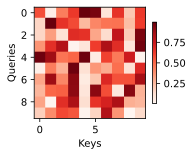

In [7]:
# Create 10x10 matrix
mat = np.random.rand(10, 10)

npx.softmax(mat)

# Define weights
W = mat.reshape((1, 1, 10, 10))
d2l.show_heatmaps(W, xlabel='Keys', ylabel='Queries')

---
### Exercise 10.3.5: 3
#### Attention Scoring Functions

When queries and keys have the same vector length, is vector summation a better design that dot product for scoring the function? Why or why not?

**Answer:**
> Given the superior computational efficiency of computing the dot product over carrying out vector summation, using the dot product would be prefereable choice. A reason for this is that vector summation carries out redundant matrix multiplication operations (each of which are computationally expensive.

---
### Exercise 10.5.4: 2
#### Multi-head Attention

Suppose that we have trained a model based on multi-headed attention and we want to prune least important attention heads to increase the prediction speed. How can we design experiments to measure the importance of an attention head?

**Answer:**
> There are two ways to approach this problem. The first would be to perform Layer-wise Relevance Propagation (LRP) to determine the contribution of given head from a network of heads, and heads with the least contribution can be pruned. Otherwise, an attention scoring function can be used, and the worst performing attention heads can be pruned such that only the high performing ones can continue.

---
### Exercise 10.7.8
#### Transformer

---
#### 10.7.8: 4
What can be challenges to transformers if input sequences are very long? Why?

> *I cannot come up with a reason since transformers are great are parallelising training, and GPUs are able to run numerous parallel processes at the same time.*

---
#### 10.7.8: 5
How to improve computational and memory efficiency of transformers? Hint: you may refer to the survey paper by Tay et al., 2020.

**Answer:**
> From the paper, I can discuss two ways of increasing computational and memory efficiency of transformers.
> 
> 1.  Memory Compressed Attention: use (strided) convolution to reduce the size of the attention matrix by reducing the number of keys and queries. A smaller attention martic means less computations.
> 2.  Limiting the attention span to a specific neighbourhood through dissecting the input into blocks of equal length, and then to perform self-attention operation. The advantage of this method is that the cost will scale linearly with the size of the input since the cost of computation is constant per block.

---
#### 10.7.8: 6
How can we design transformer-based models for image classification tasks without using CNNs? Hint: you may refer to the vision transformer [Dosovitskiy et al., 2021].

**Answer:**
> A strategy discussed in the paper to achieve transformer-based image classification is to break down the input image into sets of patches which are then fed into a regular transformer encoder network. Transformers trained on these patches appear to perform respectably so far.